In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def split_image(image_pair):
    height, width_pair = image_pair.shape
    width = int(width_pair/2)

    image_left = image_pair[0:height, 0:width]
    image_right = image_pair[0:height, width:width_pair]
    
    return image_left, image_right, (width, height)

In [3]:
left_camera_npz = np.load('./calibration_data/camera_calibration_left.npz')
left_camera_matrix = left_camera_npz['camera_matrix']
left_dist_coeff = left_camera_npz['distortion_coeff']
print(left_camera_matrix)
print(left_dist_coeff)
        
stereo_npz = np.load('./calibration_data/stereo_camera_calibration.npz')
imageSize = tuple(stereo_npz['imageSize'])
left_map_1 = stereo_npz['left_map_1']
left_map_2 = stereo_npz['left_map_2']
right_map_1 = stereo_npz['right_map_1']
right_map_2 = stereo_npz['right_map_2']
R = stereo_npz['R']
T = stereo_npz['T']
E = stereo_npz['E']
F = stereo_npz['F']
Q = stereo_npz['Q']

print(R)
print(T)
print(Q)

[[316.5971768    0.         154.25497779]
 [  0.         318.02093241 118.64072686]
 [  0.           0.           1.        ]]
[[ 2.65913078e-01 -6.64866723e-01  1.23642329e-04 -1.68039688e-03
  -3.34851919e-03]]
[[ 0.99945501 -0.00230062 -0.03293018]
 [ 0.00258005  0.99996101  0.00844561]
 [ 0.03290947 -0.00852597  0.99942197]]
[[-65.19242277]
 [ -0.23021541]
 [ -1.77505927]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.53756018e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.20883785e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20840104e+02]
 [ 0.00000000e+00  0.00000000e+00  1.53334276e-02 -0.00000000e+00]]


In [4]:
image_filename = 'dm-tune.jpg'

image_pair = cv2.imread(image_filename, cv2.IMREAD_COLOR)
image_pair = cv2.cvtColor(image_pair,cv2.COLOR_BGR2GRAY)
image_left, image_right, (width, height) = split_image(image_pair)

rectified_image_left = cv2.remap(image_left, left_map_1, left_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
rectified_image_right = cv2.remap(image_right, right_map_1, right_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

In [5]:
def stereo_depth_map(image_left, image_right):
    num_disparities = 3*16
    block_size =15
    
    # Stereo BM matcher
    sbm = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(7)
    sbm.setPreFilterCap(29)
    sbm.setMinDisparity(0)
    sbm.setNumDisparities(num_disparities)
    sbm.setTextureThreshold(13)
    sbm.setUniquenessRatio(3)
    sbm.setSpeckleRange(14)
    sbm.setSpeckleWindowSize(99)

    disparity = sbm.compute(image_left, image_right)
    
    local_max = disparity.max()
    local_min = disparity.min()
    print ("MAX " + str(local_max))
    print ("MIN " + str(local_min))
    disparity_visual = (disparity-local_min)*(1.0/(local_max-local_min))
    local_max = disparity_visual.max()
    local_min = disparity_visual.min()
    print ("MAX " + str(local_max))
    print ("MIN " + str(local_min))
    
    return disparity_visual, disparity.astype(np.float32) / 16.0

In [6]:
# Disparity map calculation
disparity_visual, disparity  = stereo_depth_map(rectified_image_left, rectified_image_right)
print(disparity.min())
print(disparity.max())

MAX 531
MIN -16
MAX 1.0
MIN 0.0
-1.0
33.1875


<IPython.core.display.Javascript object>


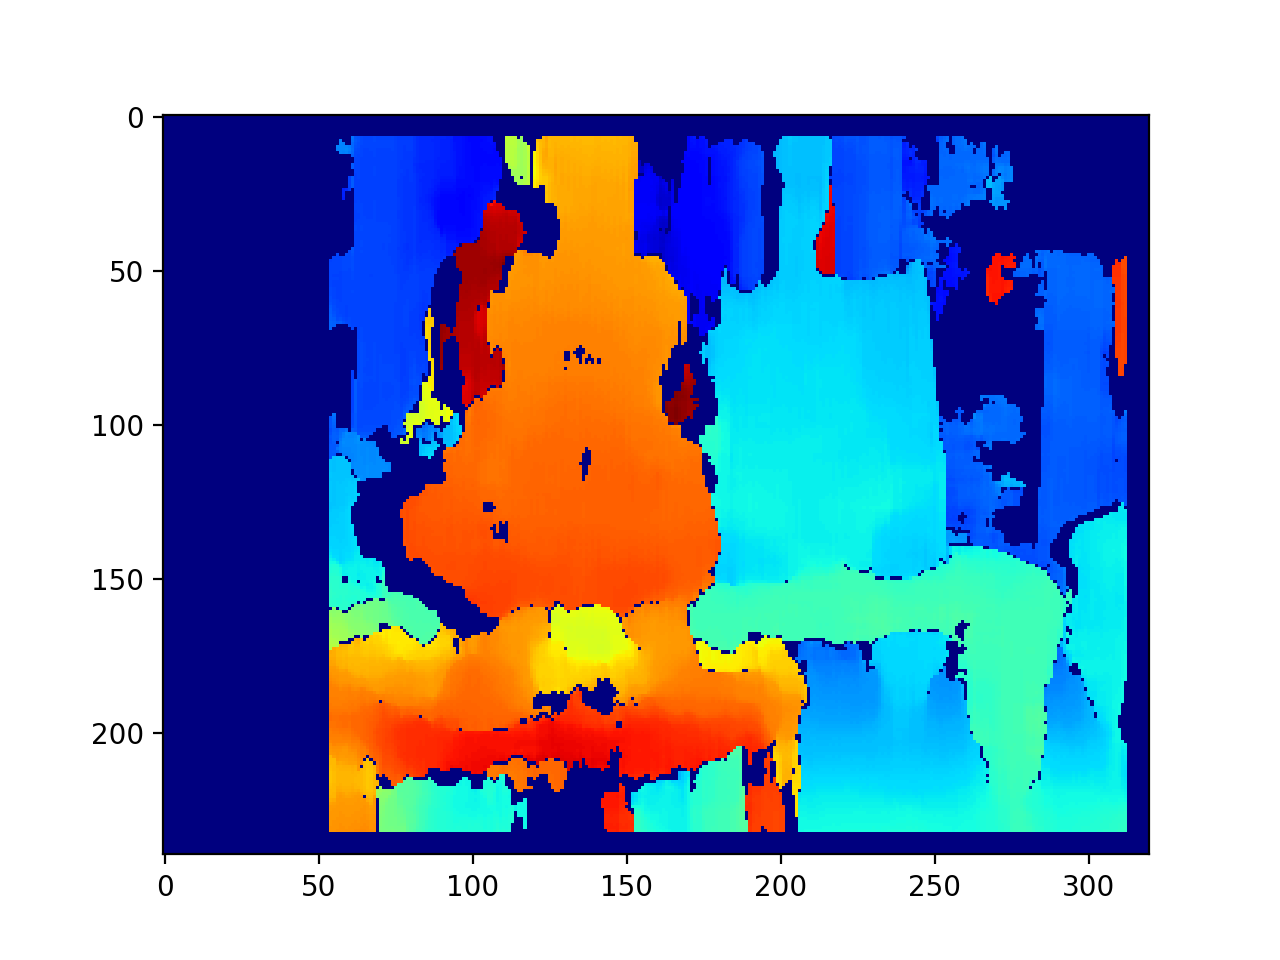

In [10]:
plt.imshow(disparity_visual, aspect='equal', cmap='jet')

In [11]:
f = left_camera_matrix[0,0]
b = -T[0]
print(f)
print(b)
safe_disparity = disparity
safe_disparity[safe_disparity == 0] = 0.1
safe_disparity[safe_disparity == -1] = 0.1

# Initialize the depth map to match the size of the disparity map
depth_map = np.ones(safe_disparity.shape, np.single)

# Calculate the depths 
depth_map[:] = f * b / safe_disparity[:]

316.5971767998715
[65.19242277]


In [12]:
depth_map[140:145,125:130] # 0.75 m

array([[769.7804 , 769.7804 , 767.99023, 766.2083 , 766.2083 ],
       [767.99023, 767.99023, 767.99023, 766.2083 , 766.2083 ],
       [767.99023, 767.99023, 766.2083 , 764.4347 , 764.4347 ],
       [766.2083 , 766.2083 , 764.4347 , 762.66925, 762.66925],
       [764.4347 , 762.66925, 762.66925, 762.66925, 760.912  ]],
      dtype=float32)

In [13]:
depth_map[125:130,200:205] # 1.75 m

array([[1785.0583, 1794.7598, 1794.7598, 1804.5671, 1814.4824],
       [1785.0583, 1785.0583, 1794.7598, 1794.7598, 1814.4824],
       [1785.0583, 1785.0583, 1785.0583, 1794.7598, 1804.5671],
       [1785.0583, 1785.0583, 1785.0583, 1794.7598, 1804.5671],
       [1785.0583, 1785.0583, 1794.7598, 1794.7598, 1804.5671]],
      dtype=float32)

In [15]:
_3dImage = cv2.reprojectImageTo3D(disparity, Q)

In [17]:
_3dImage[140:145,125:130,2]

array([[780.39075, 780.39075, 778.57587, 776.7695 , 776.7695 ],
       [778.57587, 778.57587, 778.57587, 776.7695 , 776.7695 ],
       [778.57587, 778.57587, 776.7695 , 774.9714 , 774.9714 ],
       [776.7695 , 776.7695 , 774.9714 , 773.1816 , 773.1816 ],
       [774.9714 , 773.1816 , 773.1816 , 773.1816 , 771.4001 ]],
      dtype=float32)

In [18]:
depth_map[125:130,200:205] # 1.75 m

array([[1785.0583, 1794.7598, 1794.7598, 1804.5671, 1814.4824],
       [1785.0583, 1785.0583, 1794.7598, 1794.7598, 1814.4824],
       [1785.0583, 1785.0583, 1785.0583, 1794.7598, 1804.5671],
       [1785.0583, 1785.0583, 1785.0583, 1794.7598, 1804.5671],
       [1785.0583, 1785.0583, 1794.7598, 1794.7598, 1804.5671]],
      dtype=float32)